In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

In [2]:
# DCGAN Implementation
# Discriminator
class Discriminator(nn.Module):
    def __init__(self,img_channels,features_d):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            #Input: N x img_channels x 64 x 64
            nn.Conv2d(img_channels,features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels,out_channels,kernel_size,stride,padding)
            self._block(features_d,features_d*2,4,2,1),
            self._block(features_d*2,features_d*4,4,2,1),
            self._block(features_d*4,features_d*8,4,2,1),
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),
            nn.Sigmoid()
        )

    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels,affine=True),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self,x):
        return self.disc(x)


#### Explaining the Discriminator

input: N x img_channels x 64 x 64
why 64x64? because we are using celebA dataset which is 64x64 and 3 channels (RGB), hence img_channels = 3, N is the batch size

output: N x 1 x 1 x 1
why 1x1x1? because we are using Conv2d with kernel_size=4, stride=2, padding=1, hence the image size is reduced by 2 in each dimension
hence 64 -> 32 -> 16 -> 8 -> 4 -> 2 -> 1
hence the output is N x 1 x 1 x 1
This is used to classify whether the input image is real or fake

As per the DCGAN paper, we use LeakyReLU with slope 0.2 and we use BatchNorm2d after each Conv2d layer except the last one

In [3]:
#Generator
class Generator(nn.Module):
    def __init__(self,z_dim,img_channels,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            #Input: N x z_dim x 1 x 1
            self._block(z_dim,features_g*16,4,1,0),
            self._block(features_g*16,features_g*8,4,2,1),
            self._block(features_g*8,features_g*4,4,2,1),
            self._block(features_g*4,features_g*2,4,2,1),
            nn.ConvTranspose2d(features_g*2,img_channels,kernel_size=4,stride=2,padding=1),
            nn.Tanh()
        )
    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels,affine=True),
            nn.ReLU()
        )
    
    def forward(self,x):
        return self.gen(x)
    


#### Explaining the Generator

1. Some info:
   * input: N x z_dim
   * output: N x img_channels x 64 x 64

   * We start with a linear layer to convert the input noise vector of size z_dim to a tensor of size 4x4xfeatures_g*16 (4x4 image with features_g*16 channels)
   * Then we use ConvTranspose2d to increase the image size by 2 in each dimension
   * We use BatchNorm2d after each ConvTranspose2d layer
   * We use ReLU activation function after each BatchNorm2d layer except the last one
   * The final layer uses ConvTranspose2d with kernel_size=4, stride=2, padding=1 to generate an image of size 64x64
   * In this case we use Tanh activation function so that the pixel values are in the range of -1 to 1
   * z_dim is the input noise vector size

2. What is the difference between Conv2d and ConvTranspose2d?<br>
    Conv2d is used to reduce the image size (downsampling) and ConvTranspose2d is used to increase the image size (upsampling)

3. What is the difference between BatchNorm1d and BatchNorm2d?<br>
    BatchNorm1d is used for 1D data like time series data and BatchNorm2d is used for 2D data like images

4. What is the difference between ReLU and LeakyReLU?<br>
    ReLU is Rectified Linear Unit which is max(0,x) and LeakyReLU is max(0.01x,x) or max(0.2x,x) where x is the input to the activation function (output of the linear layer)

5. What does strided convolution layers mean ?<br>
    Strided convolution layers refer to convolutional layers where the filter/kernel is applied to the input data with a certain step size or "stride" greater than 1. In a standard convolution operation, the filter slides over the input one pixel at a time, but with strided convolution, the filter moves multiple pixels at a time.

    Here's how it works:

    Standard Convolution: In a standard convolution operation, the filter/kernel moves across the input data one pixel at a time in both the horizontal and vertical directions. This is often referred to as a stride of 1.

    Strided Convolution: In a strided convolution, the filter/kernel moves across the input with a larger step size. For example, a stride of 2 means the filter moves 2 pixels at a time instead of 1. This results in a reduction of the spatial dimensions of the output feature map compared to the input.

    The main effect of using strided convolution layers is that they can help reduce the spatial dimensions of the data, effectively downsampling it. This can be useful in convolutional neural network (CNN) architectures for tasks like image classification, where reducing the spatial dimensions gradually through layers can help capture hierarchical features at different scales while reducing computational complexity.

    However, it's important to note that using strided convolutions can also result in information loss, as some of the input data may not be considered when applying the filter. Therefore, the choice of stride size needs to be carefully considered based on the specific task and architecture requirements.


6. What is batch normalization? <br>

    Batch normalization is a technique used in neural networks to normalize the input data to each layer, typically by adjusting and scaling the activations. The goal of batch normalization is to improve the training stability and speed of deep neural networks by reducing internal covariate shift.

    Here's how it works:

    1. Normalization: In batch normalization, the input data to each layer is normalized by subtracting the mean and dividing by the standard deviation of the batch of data. This helps to center and scale the data, making it more stable and easier to train.
    2. Scaling and Shifting: After normalization, the data is scaled and shifted by learnable parameters (gamma and beta) to allow the network to learn the optimal scale and shift for each layer.
    3. Batch Statistics: During training, batch normalization calculates the mean and standard deviation of the input data for each mini-batch. These batch statistics are used to normalize the data and update the running averages of the mean and standard deviation for inference.
    4. Regularization: Batch normalization acts as a form of regularization by adding noise to the input data, which can help prevent overfitting and improve generalization.
    5. Activation Function: Batch normalization is typically applied before the activation function in a neural network, helping to stabilize the activations and improve the training process.
    6. Training and Inference: During training, batch normalization uses the batch statistics to normalize the data. During inference, the running averages of the mean and standard deviation are used to normalize the data.


7. What is convtranspose? <br>

    A Convolutional Transpose, also known as a Deconvolution or a Transposed Convolution, is an operation often used in neural networks, especially in architectures like autoencoders and generative models such as variational autoencoders (VAEs) and generative adversarial networks (GANs).

    In a regular convolution operation, you apply a filter/kernel to the input data to produce a feature map, reducing the spatial dimensions of the input (e.g., going from a larger image to a smaller feature map). Convolutional transpose, on the other hand, performs the opposite operation – it upsamples the input data, increasing its spatial dimensions.

    Here's how it works:

    ConvTranspose operation involves zero-padding the input and then applying a convolution operation using a kernel that's larger than the original input.

    The convolution operation is applied with a certain stride, which determines how much the kernel shifts over the input.

    This process effectively expands the spatial dimensions of the input, producing an output with a larger spatial extent.

    ConvTranspose layers are often used in decoder parts of autoencoder architectures to reconstruct data from the learned latent space or in generator parts of GANs to upsample noise or low-resolution data into high-resolution images.

    The term "transpose" in ConvTranspose comes from the notion of transposing the convolution operation, i.e., it's like doing the reverse of a convolution. However, it's important to note that the operation itself isn't a true mathematical transpose; it's more about reversing the effects of a convolution.

In [4]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
#Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 2e-4
z_dim = 100
image_dim = 64
image_channels = 3
features_d = 64
features_g = 64
batch_size = 64
num_epochs = 5

In [6]:
# Dataset download and preprocessing
fixed_noise = torch.randn((batch_size,z_dim,1,1)).to(device)
transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(image_channels)],[0.5 for _ in range(image_channels)])
])

dataset = datasets.CIFAR10(root='dataset/',train=True,transform=transforms,download=True)
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)


100%|██████████| 170498071/170498071 [00:43<00:00, 3960050.26it/s] 


Extracting dataset/cifar-10-python.tar.gz to dataset/


In [7]:
# Initialize the Discriminator and Generator
disc = Discriminator(image_channels,features_d).to(device)
gen = Generator(z_dim,image_channels,features_g).to(device)

# Weight initialization
init_weights(disc)
init_weights(gen)

# Initialize the optimizers
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss
loss_fn = nn.BCELoss()

1. What is the role of weight initialization?<br>
    Weight initialization is important because it helps in training the model faster and more effectively by preventing the gradients from vanishing or exploding during backpropagation, this means that the model can learn the patterns in the data more effectively
<br>

2. What is this rule of mean 0 and standard deviation 1?<br>
    The "rule" of initializing weights with a mean of 0 and a standard deviation of 1 is a common practice in neural network weight initialization, particularly for certain types of layers like fully connected (dense) layers. This rule is also known as "Xavier initialization" or "Glorot initialization," named after the researchers who introduced it.

    Here's an explanation of why this rule is used and its significance:

    1. **Stabilizing Gradients**: Initializing weights with a mean of 0 helps ensure that the initial outputs of neurons are centered around 0. This can help stabilize the gradients during backpropagation, preventing them from exploding or vanishing as they propagate through the network layers.

    2. **Balancing Signal Propagation**: By setting the standard deviation to 1, the weights are initially scaled to have a moderate range of values. This helps balance the magnitude of the signal propagated forward through the network, preventing it from becoming too large or too small as it passes through multiple layers.

    3. **Improving Training Dynamics**: Proper weight initialization can lead to more stable and efficient training dynamics. It can help networks converge faster and achieve better generalization performance by ensuring that the weights are initialized in a way that facilitates effective learning.

    4. **Applicability to Different Layers**: While initializing weights with mean 0 and standard deviation 1 is commonly used for fully connected layers, variations of this rule exist for other types of layers, such as convolutional and recurrent layers. For example, Xavier initialization adapts the initialization scheme based on the number of input and output units of a layer to account for differences in signal propagation.

    Overall, initializing weights with a mean of 0 and a standard deviation of 1 is a widely adopted practice in neural network initialization because it helps address common issues related to gradient stability and signal propagation during training, contributing to more effective and efficient learning.
<br>

3. Why are we using standard deviation 0.02 for weight initialization?<br>
    This is a common practice in GANs to prevent the generator from collapsing all the generated images to a single point in the image space (mode collapse) and this is recommended in the DCGAN paper

4. But why is Xaviers initialization not used in GANs?<br>
    Xavier initialization is not used in GANs because it is designed for feedforward neural networks and may not be optimal for GANs, which have a different architecture and training dynamics. In GANs, the goal is to train a generator and a discriminator simultaneously, and the training process involves a minimax game between the two networks. The dynamics of GAN training, such as the competition between the generator and discriminator, can lead to different requirements for weight initialization compared to standard feedforward networks.

    In GANs, the choice of weight initialization can have a significant impact on the training dynamics and the quality of the generated samples. For example, using Xavier initialization in GANs may lead to issues such as mode collapse, where the generator produces limited and repetitive samples, or training instability, where the networks fail to converge to a stable equilibrium.

    Instead of Xavier initialization, GANs often use different weight initialization strategies that are tailored to the specific requirements of GAN training. For example, in DCGAN (Deep Convolutional GAN), a popular architecture for image generation, the weights of the generator and discriminator are initialized with a mean of 0 and a standard deviation of 0.02. This initialization scheme is chosen to balance the signal propagation and prevent mode collapse, helping the networks learn diverse and realistic image distributions.

    In summary, while Xavier initialization is a common practice for feedforward neural networks, it may not be suitable for GANs due to their unique architecture and training dynamics. GANs often require specialized weight initialization strategies to address challenges such as mode collapse and training instability, leading to improved performance and sample quality.

5. Then what is Kaiming initialization?<br>
    Kaiming initialization, also known as He initialization, is a weight initialization technique that is specifically designed for deep neural networks with rectified linear units (ReLUs) as activation functions. It addresses the issue of vanishing or exploding gradients that can occur during training of deep networks by initializing the weights in a way that helps stabilize the gradients and improve learning.

    Here are some key points about Kaiming initialization:

    1. **Designed for ReLU Activations**: Kaiming initialization is tailored for networks that use ReLU activation functions, which are commonly used in deep learning models due to their ability to mitigate the vanishing gradient problem. By initializing the weights in a way that accounts for the characteristics of ReLU activations, Kaiming initialization helps ensure that the gradients remain stable during training.

    2. **Mean and Variance Adjustment**: Kaiming initialization sets the mean of the weights to 0 and adjusts the variance based on the type of activation function used. For ReLU activations, the variance is scaled by a factor that depends on the number of input units to the layer, helping to balance the signal propagation and prevent the gradients from vanishing or exploding.

    3. **Improves Training Dynamics**: By initializing the weights in a way that is tailored to ReLU activations, Kaiming initialization can improve the training dynamics of deep networks. It helps networks converge faster, learn more effectively, and achieve better generalization performance by ensuring that the gradients are stable and the weights are initialized in a way that facilitates learning.

    4. **Applicability to Deep Networks**: Kaiming initialization is particularly well-suited for deep neural networks with many layers, where the vanishing gradient problem can be a significant challenge. By providing a principled way to initialize the weights based on the characteristics of ReLU activations, Kaiming initialization helps deep networks train more effectively and achieve better performance.

    In summary, Kaiming initialization is a weight initialization technique that is specifically designed for deep neural networks with ReLU activations. By setting the mean of the weights to 0 and adjusting the variance based on the type of activation function, Kaiming initialization helps stabilize the gradients and improve the training dynamics of deep networks, leading to more effective learning and better performance.

Epoch [0/5] Batch 0/782 Loss D: 0.6969, Loss G: 0.7777


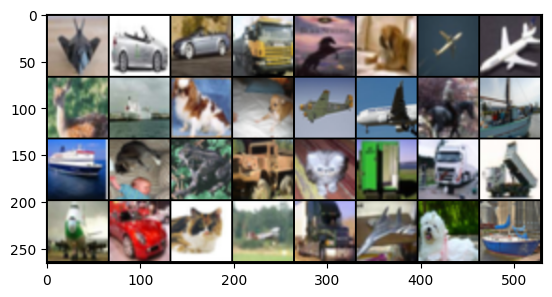

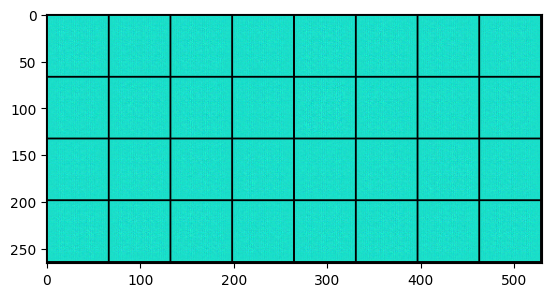

KeyboardInterrupt: 

In [8]:
loss_values = {
    'disc': [],
    'gen': []
}

# Set the models to training mode
disc.train()
gen.train()

for epoch in range(num_epochs):
    for batch_idx,(real,_) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((batch_size,z_dim,1,1)).to(device)
        fake = gen(noise)
        
        disc_real = disc(real).view(-1)
        lossD_real = loss_fn(disc_real,torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = loss_fn(disc_fake,torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        output = disc(fake).view(-1)
        lossG = loss_fn(output,torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")
            loss_values['disc'].append(lossD.item())
            loss_values['gen'].append(lossG.item())
            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = real[:32]
                img_grid_fake = fake[:32]
                img_grid_real = torchvision.utils.make_grid(img_grid_real,normalize=True).cpu()
                img_grid_fake = torchvision.utils.make_grid(img_grid_fake,normalize=True).cpu()

                plt.imshow(np.transpose(img_grid_real.numpy(),(1,2,0)))
                plt.show()
                plt.imshow(np.transpose(img_grid_fake.numpy(),(1,2,0)))
                plt.show()

# Save the model
torch.save(gen.state_dict(), 'gen.pth')
torch.save(disc.state_dict(), 'disc.pth')


In [ ]:
# Plot the loss values
plt.plot(loss_values['disc'], label='Discriminator')
plt.plot(loss_values['gen'], label='Generator')
plt.title('Loss Values')
plt.legend()
plt.show()